# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os
import itertools
import glob
import shutil
import nibabel as nib
import nilearn
from nilearn.image import resample_to_img
from nilearn.image import load_img
import re
import matplotlib.pyplot as plt
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load brain mask and resamples image files directly under data folder
# MNI152_T1_1mm_brain_mask.nii.gz
# MNI152_T1_!mm.nii.gz
# https://git.fmrib.ox.ac.uk/falmagro/UK_biobank_pipeline_v_1/-/tree/master?ref_type=heads

# Re-Organization of Data

In [3]:
def split_and_clean(metadata_csv_path, output_tsv_path, dx_name, age_name, sex_name, random_state=42):
    # Load metadata
    df = pd.read_csv(metadata_csv_path, sep="\t", dtype=str)
    df = df.rename(columns={
        dx_name : 'label',
        age_name : 'age',
        sex_name : 'sex'
    })

    # Change labels: 1 -> 1 (Autism), 2 -> 0 (non-Autism)
    df["label"] = df["label"].replace('2', '0')
    # Change labels: 1 -> 1 (Male), 2 -> 0 (Female)
    df["sex"] = df["sex"].replace('2', '0')

    np.random.seed(random_state)

    # Step 1: Shuffle and sort sites by participant count
    site_counts = df['site_id'].value_counts().to_dict()
    sites_sorted = sorted(site_counts.items(), key=lambda x: -x[1])
    
    test_sites = []
    test_count = 0
    total_subjects = len(df)
    target_test_count = int(0.15 * total_subjects)

    for site, count in sites_sorted:
        if test_count + count <= target_test_count or len(test_sites) == 0:
            test_sites.append(site)
            test_count += count
        if test_count >= target_test_count:
            break

    # Assign datasets
    df['dataset'] = 'trainval'
    df.loc[df['site_id'].isin(test_sites), 'dataset'] = 'test'

    # Step 2: Stratified val split from remaining trainval
    trainval_df = df[df['dataset'] == 'trainval'].copy()
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1765, random_state=random_state)
    # Why 0.1765? Because 15% of the total ≈ 17.65% of the 85% that remains after test

    strat_labels = trainval_df['label']
    for train_idx, val_idx in sss.split(trainval_df, strat_labels):
        trainval_df.loc[trainval_df.iloc[val_idx].index, 'dataset'] = 'val'
        trainval_df.loc[trainval_df.iloc[train_idx].index, 'dataset'] = 'train'

    # Step 3: Merge back with test data
    final_df = pd.concat([trainval_df, df[df['dataset'] == 'test']], axis=0)
    final_df = final_df[['participant_id', 'label', 'dataset', 'age', 'sex', 'site_id']]

    # Save to .tsv
    final_df.to_csv(output_tsv_path, sep='\t', index=False)

    # Print summary
    print("\nSummary Table (Label Counts by Dataset):")
    print(final_df.groupby(['dataset', 'label']).size().unstack(fill_value=0))

    return final_df

## ABIDEI

### Combine CSV Files

In [38]:
# ABIDEI
input_path = '/scratch/ejh2wy/data/ABIDE1/'
output_path = '../ABIDE_Dataset/data/ABIDEI/'

# Create directories if they don't exist
os.makedirs(output_path, exist_ok=True)

abide1 = pd.DataFrame()
for item in os.listdir(input_path):
    item_path = os.path.join(input_path, item)
    if (item != 'derivatives') and (item != 'correct_bids.py') and (item != 'sidecards'):
        subjects = pd.read_csv(os.path.join(item_path, 'participants.tsv'), sep='\t')
        subjects = subjects[['participant_id', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX']]
        subjects['site_id'] = item
        abide1 = pd.concat([abide1, subjects], ignore_index=True)
print(abide1)

abide1.to_csv(os.path.join(output_path, 'participants.tsv'), sep='\t', index=False)

     participant_id  DX_GROUP  AGE_AT_SCAN  SEX site_id
0         sub-51291         1        16.47    1  UCLA_2
1         sub-51292         1        12.24    1  UCLA_2
2         sub-51293         1        13.08    1  UCLA_2
3         sub-51294         1        11.70    1  UCLA_2
4         sub-51295         1        10.04    1  UCLA_2
...             ...       ...          ...  ...     ...
1107      sub-51153         2        26.17    1     NYU
1108      sub-51154         2        30.08    1     NYU
1109      sub-51155         2        30.78    1     NYU
1110      sub-51156         2        21.15    1     NYU
1111      sub-51159         2        12.81    1     NYU

[1112 rows x 5 columns]


### Train/Test/Split and participants.tsv Creation

In [39]:
#df_summary = summary_abide1  # From your earlier pivoted table
metadata_path = '../ABIDE_Dataset/data/ABIDEI/participants.tsv'  # Replace with your path
output_path = '../ABIDE_Dataset/data/ABIDEI/participants.tsv'

# Create Dataset Split Column and Save
split_and_clean(metadata_path, output_path, 'DX_GROUP', 'AGE_AT_SCAN', 'SEX')


Summary Table (Label Counts by Dataset):
label      0    1
dataset          
test     105   79
train    385  379
val       83   81


,participant_id,label,dataset,age,sex,site_id
0,sub-51291,1,train,16.47,1,UCLA_2
1,sub-51292,1,train,12.24,1,UCLA_2
2,sub-51293,1,train,13.08,1,UCLA_2
3,sub-51294,1,val,11.7,1,UCLA_2
4,sub-51295,1,train,10.04,1,UCLA_2
...,...,...,...,...,...,...
1107,sub-51153,0,test,26.17,1,NYU
1108,sub-51154,0,test,30.08,1,NYU
1109,sub-51155,0,test,30.78,1,NYU
1110,sub-51156,0,test,21.15,1,NYU


### BIDS Structure - Move Data Needed

In [40]:
# Define the original root and new destination directory
root_dir = "/scratch/ejh2wy/data/ABIDE1" # Directory with original files
new_root_dir = "../ABIDE_Dataset/data/ABIDEI"  # New directory to store the copied files

In [41]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", dtype=str)
print(len(test))

1112


In [42]:
# Find all files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/derivatives/fmriprep/sub-*/anat/sub-*_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) # only 985/1112 found

985


In [43]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #987 - found 2 extra somehow

Reorganization complete! Files copied to: ./data/ABIDEI
987


In [44]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", dtype=str)

# Add 2 leading zeros for ABIDEI
df_participants['participant_id'] = df_participants['participant_id'].apply(
    lambda x: f"sub-{int(x.split('-')[1]):07d}"
)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"{subid}", "anat", f"{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #985 - match!

985


### Brain Masks

In [45]:
# Define the original root and new destination directory
root_dir = "/scratch/ejh2wy/data/ABIDE1" # Directory with original files
new_root_dir = "../ABIDE_Dataset/data/ABIDEI_Masks"  # New directory to store the copied files

# Create directories if they don't exist
os.makedirs(new_root_dir, exist_ok=True)

In [46]:
# Find all files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/derivatives/fmriprep/sub-*/anat/sub-*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"), recursive=True)
print(len(t1w_files)) # 985 - same as images

985


In [47]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_mask.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Move the file instead of copying - running out of space
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #985 - match!

Reorganization complete! Files copied to: ./data/ABIDEI_Masks
985


## ABIDEII

### Combine CSV Files

In [50]:
# ABIDEII
input_path = "/scratch/ejh2wy/data/ABIDEII/"
output_path = '../ABIDE_Dataset/data/ABIDEII/'

# Create directories if they don't exist
os.makedirs(output_path, exist_ok=True)

abide2 = pd.DataFrame()
for item in os.listdir(input_path):
    item_path = os.path.join(input_path, item)
    if (item != 'ABIDEII-ETHZ_1') and (item != 'correct_bids.py') and (item != 'ABIDEII-UPSM_Long') and (item != 'ABIDEII-UCLA_Long'):
        subjects = pd.read_csv(os.path.join(item_path, 'participants.tsv'), sep='\t')
        subjects = subjects[['site_id', 'participant_id', 'dx_group', 'age_at_scan ', 'sex']]
        subjects['site_id'] = item
        abide2 = pd.concat([abide2, subjects], ignore_index=True)
print(abide2)

abide2.to_csv(os.path.join(output_path, 'participants.tsv'), sep='\t', index=False)

            site_id participant_id  dx_group  age_at_scan   sex
0     ABIDEII-KKI_1      sub-29273         1      8.476712    1
1     ABIDEII-KKI_1      sub-29274         1      9.246575    1
2     ABIDEII-KKI_1      sub-29275         1      8.646575    1
3     ABIDEII-KKI_1      sub-29276         1      9.216438    2
4     ABIDEII-KKI_1      sub-29277         1     12.789041    1
...             ...            ...       ...           ...  ...
1002  ABIDEII-NYU_2      sub-29172         1      7.750000    1
1003  ABIDEII-NYU_2      sub-29173         1      5.819000    2
1004  ABIDEII-NYU_2      sub-29174         1      5.295000    1
1005  ABIDEII-NYU_2      sub-29175         1      7.876000    1
1006  ABIDEII-NYU_2      sub-29176         1      5.951000    1

[1007 rows x 5 columns]


### Train/Test/Split and participants.tsv Creation

In [52]:
metadata_path = '../ABIDE_Dataset/data/ABIDEII/participants.tsv'  # Replace with your path
output_path = '../ABIDE_Dataset/data/ABIDEII/participants.tsv'

split_and_clean(metadata_path, output_path, 'dx_group', 'age_at_scan ', 'sex')


Summary Table (Label Counts by Dataset):
label      0    1
dataset          
test     155   56
train    311  344
val       67   74


,participant_id,label,dataset,age,sex,site_id
211,sub-28920,1,val,14.0,1,ABIDEII-OHSU_1
212,sub-28924,1,train,12.0,1,ABIDEII-OHSU_1
213,sub-28925,1,train,9.0,1,ABIDEII-OHSU_1
214,sub-28926,1,train,11.0,1,ABIDEII-OHSU_1
215,sub-28927,1,val,13.0,1,ABIDEII-OHSU_1
...,...,...,...,...,...,...
206,sub-29476,0,test,11.65753425,1,ABIDEII-KKI_1
207,sub-29478,0,test,10.58630137,1,ABIDEII-KKI_1
208,sub-29480,0,test,12.60547945,1,ABIDEII-KKI_1
209,sub-29483,0,test,9.632876712,1,ABIDEII-KKI_1


### BIDS Structure - Move Data Needed

In [53]:
# Define the original root and new destination directory
root_dir = "/scratch/ejh2wy/data/ABIDEII" # Directory with original files
new_root_dir = "../ABIDE_Dataset/data/ABIDEII"  # New directory to store the copied files

In [54]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", dtype=str)
print(len(test))

1007


In [55]:
# Find all files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/derivatives/fmriprep/sub-*/ses-1/anat/sub-*_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) # only 960/1007 found - likely multiple runs for some subjects

960


In [56]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("ses-1") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Move the file instead of copying - running out of space
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #961 - found 1 extra somehow

Reorganization complete! Files copied to: ./data/ABIDEII
961


In [57]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"{subid}", "anat", f"{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #924 - somehow less

924


### Brain Masks

In [58]:
# Define the original root and new destination directory
root_dir = "/scratch/ejh2wy/data/ABIDEII" # Directory with original files
new_root_dir = "../ABIDE_Dataset/data/ABIDEII_Masks"  # New directory to store the copied files

# Create directories if they don't exist
os.makedirs(new_root_dir, exist_ok=True)

In [59]:
# Find all files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/derivatives/fmriprep/sub-*/ses-1/anat/sub-*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"), recursive=True)
print(len(t1w_files)) # 960 - same number of masks as images

960


In [60]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("ses-1") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_mask.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Move the file instead of copying - running out of space
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #960 - match!

Reorganization complete! Files copied to: ./data/ABIDEII_Masks
960


## Check Image

In [7]:
image_path = "../ABIDE_Dataset/data/ABIDEII/sub-28817/anat/sub-28817_T1w.nii.gz"

img = nib.load(image_path)

data = np.squeeze(img.get_fdata()) #might not need squeeze

print(data.shape)
print(data.min())
print(data.max())

(193, 229, 193)
-99.06421661376953
862.57080078125


Axial shape: (193, 229)
Coronal shape: (193, 193)
Sagittal shape: (229, 193)


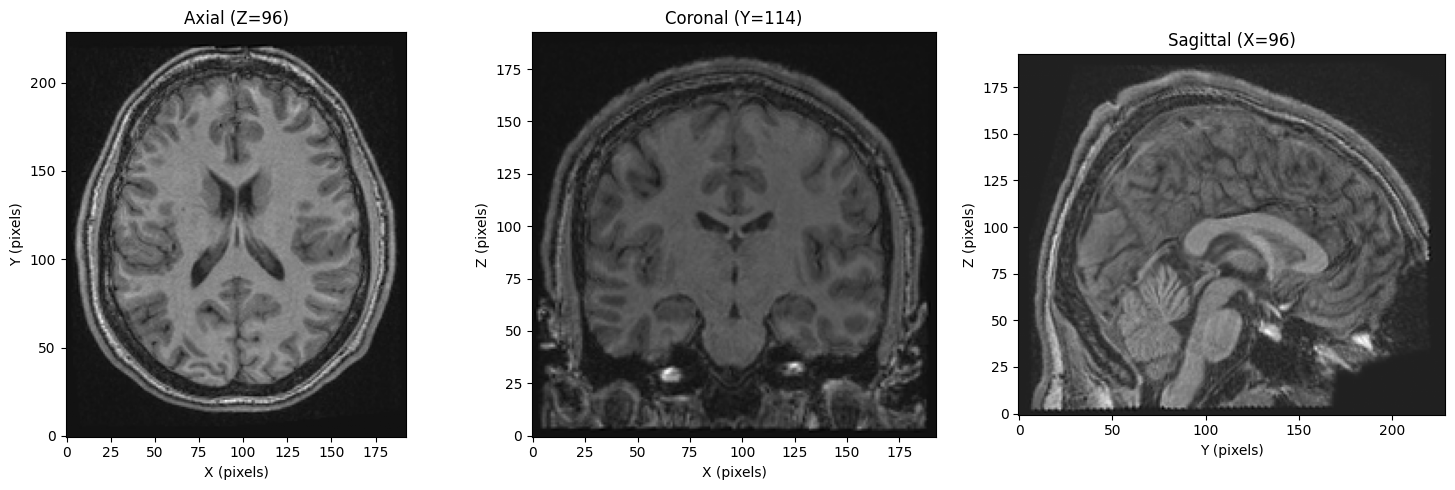

In [8]:
# Visualize
# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

print("Axial shape:", data[:, :, mid_z].shape)
print("Coronal shape:", data[:, mid_y, :].shape)
print("Sagittal shape:", data[mid_x, :, :].shape)

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()

# Resample (1 mm)

## ABIDEI

In [2]:
# Paths
target_img_path = '../ABIDE_Dataset/data/MNI152_T1_1mm.nii.gz'
input_dir = "../ABIDE_Dataset/data/ABIDEI"
output_dir = "../ABIDE_Dataset/data/Resampled/ABIDEI"

# Load target image once globally
target_img = nib.load(target_img_path)

# Find input files
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(f"Found {len(t1w_files)} files.")

# Precompile regex
regex = re.compile(r"^(?:[^\/]*\/){3}(.*)$")

def process_file(file_path):
    try:
        relative_path = regex.match(file_path).group(1)
        input_path = os.path.join(input_dir, relative_path)
        output_path = os.path.join(output_dir, relative_path)

        if os.path.exists(output_path):
            return  # silently skip

        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Resample and save
        resampled_img = resample_to_img(input_path, target_img, force_resample=True, copy_header=True)
        nib.save(resampled_img, output_path)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Use all available CPU cores
max_workers = os.cpu_count()

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_file, f) for f in t1w_files]
    for future in as_completed(futures):
        _ = future.result()  # discard result

print("Finished processing all files.")

Found 985 files.
Finished processing all files.


In [3]:
# Double Check all Files copied over
t1w_files = glob.glob(os.path.join(output_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files))

985


## ABIDEII

In [2]:
# Paths
target_img_path = '../ABIDE_Dataset/data/MNI152_T1_1mm.nii.gz'
input_dir = "../ABIDE_Dataset/data/ABIDEII"
output_dir = "../ABIDE_Dataset/data/Resampled/ABIDEII"

# Load target image once globally
target_img = nib.load(target_img_path)

# Find input files
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(f"Found {len(t1w_files)} files.")

# Precompile regex
regex = re.compile(r"^(?:[^\/]*\/){3}(.*)$")

def process_file(file_path):
    try:
        relative_path = regex.match(file_path).group(1)
        input_path = os.path.join(input_dir, relative_path)
        output_path = os.path.join(output_dir, relative_path)

        if os.path.exists(output_path):
            return  # silently skip

        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Resample and save
        resampled_img = resample_to_img(input_path, target_img, force_resample=True, copy_header=True)
        nib.save(resampled_img, output_path)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Use all available CPU cores
max_workers = os.cpu_count()

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_file, f) for f in t1w_files]
    for future in as_completed(futures):
        _ = future.result()  # discard result

print("Finished processing all files.")

Found 960 files.
Finished processing all files.


In [4]:
# Double Check all Files copied over
t1w_files = glob.glob(os.path.join(output_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files))

960


### Check Image

In [11]:
image_path = "../ABIDE_Dataset/data/Resampled/ABIDEII/sub-28817/anat/sub-28817_T1w.nii.gz"

img = nib.load(image_path)

data = np.squeeze(img.get_fdata()) #might not need squeeze

print(data.shape)
print(data.min())
print(data.max())

(182, 218, 182)
-90.45413208007812
862.57080078125


Axial shape: (182, 218)
Coronal shape: (182, 182)
Sagittal shape: (218, 182)


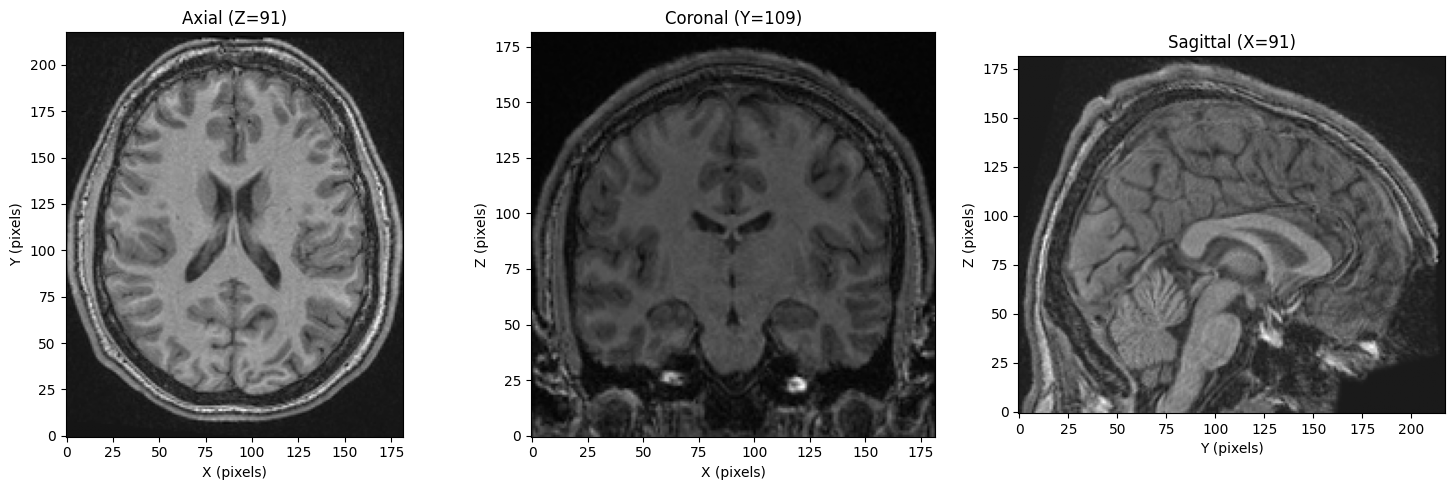

In [12]:
# Visualize
# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

print("Axial shape:", data[:, :, mid_z].shape)
print("Coronal shape:", data[:, mid_y, :].shape)
print("Sagittal shape:", data[mid_x, :, :].shape)

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()

# Remove Skull

## ABIDEI

In [10]:
# Reference Mask Image for Resampling
target_img = '../ABIDE_Dataset/data/MNI152_T1_1mm_brain_mask.nii.gz'

# Define directories
mask_dir = "../ABIDE_Dataset/data/ABIDEI_Masks"
input_dir = "../ABIDE_Dataset/data/Resampled/ABIDEI"
output_dir = "../ABIDE_Dataset/data/JustBrain/ABIDEI"

# Create the output root if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"))
print(f"Found {len(t1w_files)} files")

def process_file(filename):
    try:
        # Extract relative path
        relative_path = re.match(r"^(?:[^\/]*\/){4}(.*)$", filename).group(1)
        new_filename = relative_path.replace("_T1w.nii.gz", "_mask.nii.gz")
        
        # Paths
        mask_input_path = os.path.join(mask_dir, new_filename)
        img_input_path = os.path.join(input_dir, relative_path)
        output_path = os.path.join(output_dir, relative_path)

        if not os.path.isfile(output_path):
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Resample and mask
            resampled_mask = resample_to_img(mask_input_path, target_img, interpolation='nearest', force_resample=True, copy_header=True)
            mask_array = resampled_mask.get_fdata()
            img = nib.load(img_input_path)
            img_array = img.get_fdata()

            masked_img = mask_array * img_array
            masked_nii = nib.Nifti1Image(masked_img, affine=img.affine, header=img.header)
            nib.save(masked_nii, output_path)

        return True
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return False

# Run in parallel
if __name__ == "__main__":
    with ProcessPoolExecutor() as executor:
        list(tqdm(executor.map(process_file, t1w_files), total=len(t1w_files)))

    print("Finished processing all files.")


Found 985 files


100%|██████████| 985/985 [02:06<00:00,  7.79it/s]


Finished processing all files.


In [11]:
# Double Check all Files copied over
t1w_files = glob.glob(os.path.join(output_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files))

985


## ABIDEII

In [15]:
# Reference Mask Image for Resampling
target_img = '../ABIDE_Dataset/data/MNI152_T1_1mm_brain_mask.nii.gz'

# Define directories
mask_dir = "../ABIDE_Dataset/data/ABIDEII_Masks"
input_dir = "../ABIDE_Dataset/data/Resampled/ABIDEII"
output_dir = "../ABIDE_Dataset/data/JustBrain/ABIDEII"

# Create the output root if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"))
print(f"Found {len(t1w_files)} files")

def process_file(filename):
    try:
        # Extract relative path
        relative_path = re.match(r"^(?:[^\/]*\/){4}(.*)$", filename).group(1)
        new_filename = relative_path.replace("_T1w.nii.gz", "_mask.nii.gz")
        
        # Paths
        mask_input_path = os.path.join(mask_dir, new_filename)
        img_input_path = os.path.join(input_dir, relative_path)
        output_path = os.path.join(output_dir, relative_path)

        if not os.path.isfile(output_path):
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Resample and mask
            resampled_mask = resample_to_img(mask_input_path, target_img, interpolation='nearest', force_resample=True, copy_header=True)
            mask_array = resampled_mask.get_fdata()
            img = nib.load(img_input_path)
            img_array = img.get_fdata()

            masked_img = mask_array * img_array
            masked_nii = nib.Nifti1Image(masked_img, affine=img.affine, header=img.header)
            nib.save(masked_nii, output_path)

        return True
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return False

# Run in parallel
if __name__ == "__main__":
    with ProcessPoolExecutor() as executor:
        list(tqdm(executor.map(process_file, t1w_files), total=len(t1w_files)))

    print("Finished processing all files.")


Found 960 files


100%|██████████| 960/960 [02:04<00:00,  7.73it/s]


Finished processing all files.


In [16]:
# Double Check all Files copied over
t1w_files = glob.glob(os.path.join(output_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files))

960


### Check Image

In [17]:
image_path = "../ABIDE_Dataset/data/JustBrain/ABIDEII/sub-28817/anat/sub-28817_T1w.nii.gz"

img = nib.load(image_path)

data = np.squeeze(img.get_fdata()) #might not need squeeze

print(data.shape)
print(data.min())
print(data.max())

(182, 218, 182)
-32.48150634765625
525.044189453125


Axial shape: (182, 218)
Coronal shape: (182, 182)
Sagittal shape: (218, 182)


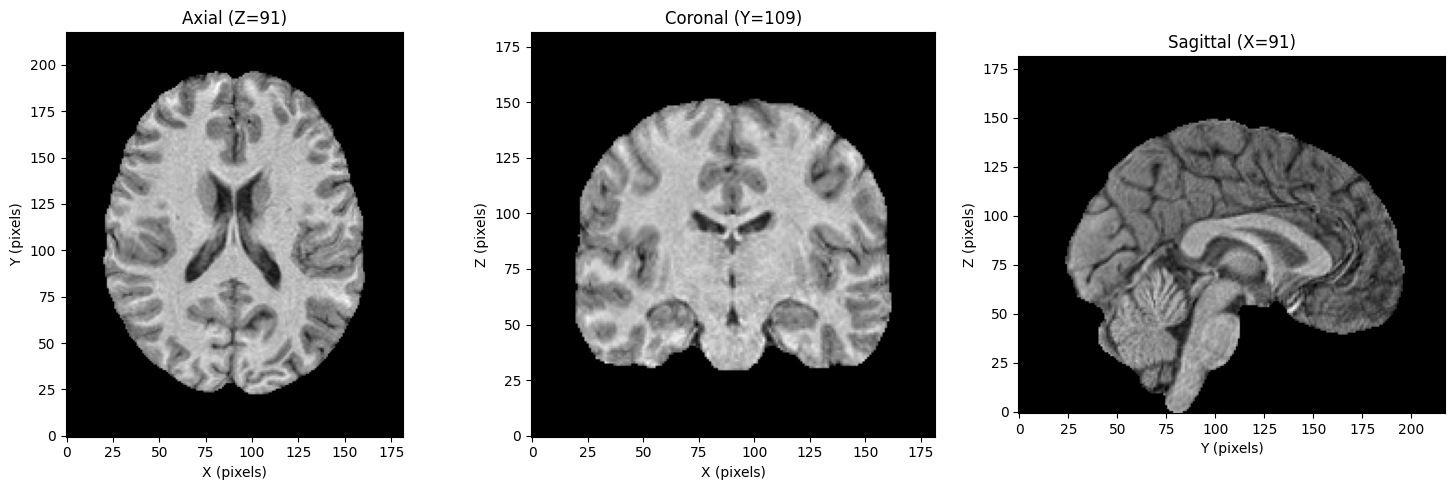

In [18]:
# Visualize
# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

print("Axial shape:", data[:, :, mid_z].shape)
print("Coronal shape:", data[:, mid_y, :].shape)
print("Sagittal shape:", data[mid_x, :, :].shape)

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()

# New Participants.tsv split with sex

## ABIDEI

In [44]:
# Load metadata
metadata_path = '../ABIDE_Dataset/data/ABIDEI/participants.tsv'  # Replace with your path
output_path = './ABIDEI/participants.tsv'
df = pd.read_csv(metadata_path, sep="\t", dtype=str)

# Drop Autism and add Sex as Label
df.drop(columns=['dataset'], inplace=True)
df = df.rename(columns={'label': 'ASD', 'sex': 'label'})

X_train, X_test, y_train, y_test = train_test_split(df[['participant_id','age','ASD', 'site_id']], df['label'], test_size=0.15, random_state=42, stratify=df['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42, stratify=y_train) # 0.18 x 0.85 = 0.15

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_test, y_test = undersample.fit_resample(X_test, y_test)
X_val, y_val = undersample.fit_resample(X_val, y_val)


# Add Dataset to csv
X_train['dataset'] = 'train'
X_train['label'] = y_train
X_test['dataset'] = 'test'
X_test['label'] = y_test
X_val['dataset'] = 'val'
X_val['label'] = y_val

final_df = pd.concat([X_train, X_test, X_val], ignore_index=True)


# Save to .tsv
final_df.to_csv(output_path, sep='\t', index=False)

# Print summary
print("\nSummary Table (Label Counts by Dataset):")
print(final_df.groupby(['dataset', 'label']).size().unstack(fill_value=0))

''' #Original
Summary Table (Label Counts by Dataset):
label      0    1
dataset          
test      23  125
train    109  577
val       24  127
'''


Summary Table (Label Counts by Dataset):
label      0    1
dataset          
test      23   23
train    109  109
val       24   24


' #Original\nSummary Table (Label Counts by Dataset):\nlabel      0    1\ndataset          \ntest      23  125\ntrain    109  577\nval       24  127\n'

## ABIDEII

In [45]:
metadata_path = '../ABIDE_Dataset/data/ABIDEII/participants.tsv'  # Replace with your path
output_path = './ABIDEII/participants.tsv'
df = pd.read_csv(metadata_path, sep="\t", dtype=str)

# Drop Autism and add Sex as Label
df.drop(columns=['dataset'], inplace=True)
df = df.rename(columns={'label': 'ASD', 'sex': 'label'})

X_train, X_test, y_train, y_test = train_test_split(df[['participant_id','age','ASD', 'site_id']], df['label'], test_size=0.15, random_state=42, stratify=df['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42, stratify=y_train) # 0.18 x 0.85 = 0.15

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_test, y_test = undersample.fit_resample(X_test, y_test)
X_val, y_val = undersample.fit_resample(X_val, y_val)


# Add Dataset to csv
X_train['dataset'] = 'train'
X_train['label'] = y_train
X_test['dataset'] = 'test'
X_test['label'] = y_test
X_val['dataset'] = 'val'
X_val['label'] = y_val

final_df = pd.concat([X_train, X_test, X_val], ignore_index=True)


# Save to .tsv
final_df.to_csv(output_path, sep='\t', index=False)

# Print summary
print("\nSummary Table (Label Counts by Dataset):")
print(final_df.groupby(['dataset', 'label']).size().unstack(fill_value=0))


Summary Table (Label Counts by Dataset):
label      0    1
dataset          
test      34   34
train    159  159
val       35   35
